In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import yfinance as yf


In [22]:
# Define a function for future prediction
def predict_future_prices(model, last_sequence, future_time_steps, scaler):
    future_predictions = []

    for _ in range(future_time_steps):
        # Predict the next price
        next_price = model.predict(last_sequence.reshape(1, sequence_length, 1))

        # Append the predicted price to the list
        future_predictions.append(next_price[0, 0])

        # Update the last_sequence by removing the first element and adding the predicted price
        last_sequence = np.concatenate((last_sequence[1:], next_price), axis=None)

    # Inverse transform the scaled predictions to original prices
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions
# Load your dataset. Uncomment the index of your choice
sp500 = yf.Ticker("^GSPC")    # For S&P500
# sp500 = yf.Ticker("NDAQ")    # For NASDAQ
# sp500 = yf.Ticker("AAPL")    # For Apple
sp500 = sp500.history(period="max")
sp500.to_csv("sp500.csv")
sp500.index = pd.to_datetime(sp500.index)

<Axes: xlabel='Date'>

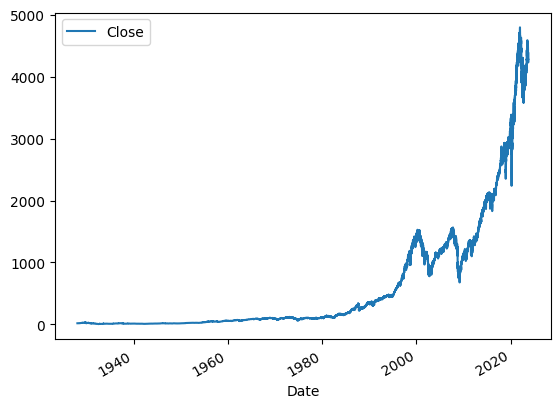

In [23]:
# Plot 'Close' stock prices for whole timeline
sp500.plot.line(y="Close", use_index=True)

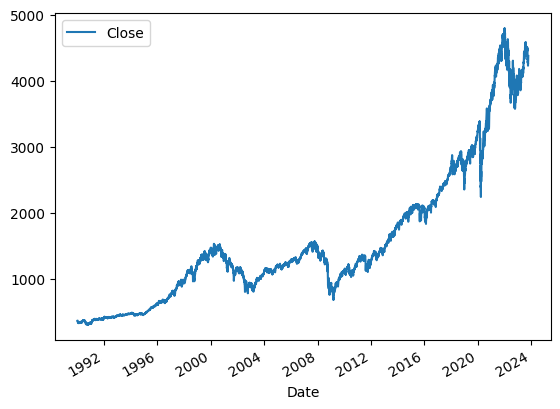

In [24]:
# Only use values after the year 1990
sp500 = sp500.loc["1990-01-01":].copy()
sp500.plot.line(y="Close", use_index=True)    # Plot the 'Close' data again, starting from later date

# Extract only the closing prices
prices = sp500['Close'].values.reshape(-1, 1)

In [25]:
# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

In [26]:
# Use only initial 95% of data for training, the rest for testing
train_size = int(len(prices_scaled) * 0.95)
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size:]

In [27]:
sequence_length = 20  # How many days we want to look back for training and giving a prediction
def create_sequences(data, sequence_length):
    sequences = []
    targets = []  # Create a separate list for targets
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)  # Return sequences and targets as separate arrays

train_sequences, train_targets = create_sequences(train_data, sequence_length)
test_sequences, test_targets = create_sequences(test_data, sequence_length)

In [28]:
model = Sequential()

# A shallow NN
# Give RSME of (train, test) = (43.79, 132.70)
# A shalow network is NOT good
# model.add(LSTM(units=50, input_shape=(sequence_length, 1)))
# model.add(Dense(units=1))

# A deeper NN
# Train Score: 35.98 RMSE
# Test Score: 102.16 RMSE
# With 100 Epochs
# Train Score: 29.25 RMSE
# Test Score: 71.73 RMSE
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
train_sequences, train_targets = create_sequences(train_data, sequence_length)
# Then, use train_sequences and train_targets in model.fit
model.fit(train_sequences, train_targets, epochs=40, batch_size=64)

Epoch 1/40
126/126 [==============================] - 4s 13ms/step - loss: 0.0038
Epoch 2/40
126/126 [==============================] - 2s 13ms/step - loss: 9.5185e-05
Epoch 3/40
126/126 [==============================] - 2s 13ms/step - loss: 8.9266e-05
Epoch 4/40
126/126 [==============================] - 2s 12ms/step - loss: 8.6801e-05
Epoch 5/40
126/126 [==============================] - 2s 12ms/step - loss: 8.8541e-05
Epoch 6/40
126/126 [==============================] - 2s 13ms/step - loss: 8.0186e-05
Epoch 7/40
126/126 [==============================] - 2s 13ms/step - loss: 7.5994e-05
Epoch 8/40
126/126 [==============================] - 2s 13ms/step - loss: 7.7767e-05
Epoch 9/40
126/126 [==============================] - 2s 13ms/step - loss: 7.3639e-05
Epoch 10/40
126/126 [==============================] - 2s 12ms/step - loss: 6.6556e-05
Epoch 11/40
126/126 [==============================] - 2s 12ms/step - loss: 6.6898e-05
Epoch 12/40
126/126 [==============================] - 2

In [30]:
# # Modify this line to convert the sequences to a tuple of NumPy arrays
# test_input = np.array([sequence for sequence, _ in test_sequences])
# test_target = np.array([target for _, target in test_sequences])
#
# test_loss = model.evaluate(test_input, test_target)
#
# # Make predictions on the test set
# predicted_prices = model.predict(test_input)
#
# # Inverse transform the scaled predictions to original prices
# predicted_prices = scaler.inverse_transform(predicted_prices)

# Modify this line to create separate arrays for sequences and targets
test_sequences, test_targets = create_sequences(test_data, sequence_length)

# Then, use test_sequences and test_targets in model.evaluate and model.predict
test_loss = model.evaluate(test_sequences, test_targets)

# Make predictions on the test set
predicted_prices = model.predict(test_sequences)

# Inverse transform the scaled predictions to original prices
predicted_prices = scaler.inverse_transform(predicted_prices)


13/13 [==============================] - 1s 4ms/step


In [31]:
# Get the models predicted price values
train_predict = model.predict(train_sequences)
test_predict = model.predict(test_sequences)

# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

13/13 [==============================] - 0s 4ms/step


In [32]:
# Get the root mean squared error (RMSE)
rmse_train = np.sqrt(np.mean(((train_predict - scaler.inverse_transform(train_targets)) ** 2)))
rmse_test  = np.sqrt(np.mean(((test_predict  - scaler.inverse_transform(test_targets))  ** 2)))

print('Train Score: %.2f RMSE' % (rmse_train))
print('Test Score: %.2f RMSE' % (rmse_test))

Train Score: 31.75 RMSE
Test Score: 68.33 RMSE


1/1 [==============================] - 0s 16ms/step


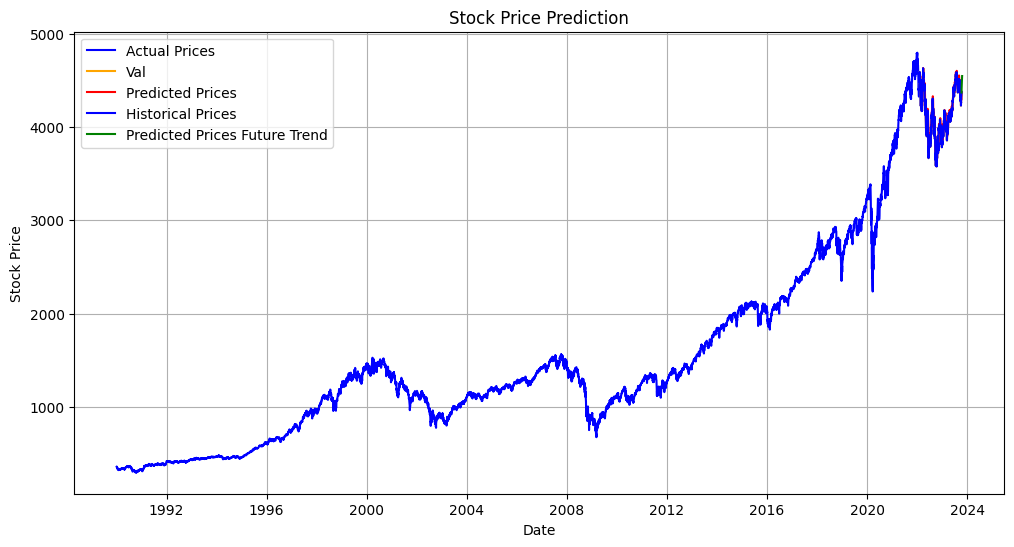

In [33]:
# Plot the actual historical data and predicted future prices
plt.figure(figsize=(12, 6))
# plt.plot(sp500['Date'], sp500['Close'], label='Historical Prices', color='blue')
# plt.plot(sp500.index, sp500['Close'], label='Historical Prices', color='black')   # Works fine
plt.plot(sp500.index[:train_size], prices[:train_size], label='Actual Prices', color='blue')
plt.plot(sp500.index[train_size:], prices[train_size:], label='Val', color='orange')
plt.plot(sp500.index[train_size+sequence_length:train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')
# Future prediction
# Get the most recent sequence from your test data
last_sequence = test_sequences[-1]

# Number of future time steps to predict
future_time_steps = 10  # Adjust as needed

# Predict future prices
future_predictions = predict_future_prices(model, last_sequence, future_time_steps, scaler)

# Create a time axis for future predictions without the last element
time_axis = pd.date_range(start=sp500.index[-1], periods=future_time_steps)

# Plot the actual historical data and predicted future prices
plt.plot(sp500.index[train_size:], sp500['Close'][train_size:], label='Historical Prices', color='blue')
plt.plot(time_axis, future_predictions, label='Predicted Prices Future Trend', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid()
plt.show()

In [34]:
predicted_prices.shape
sp500.index[train_size:].shape

(426,)

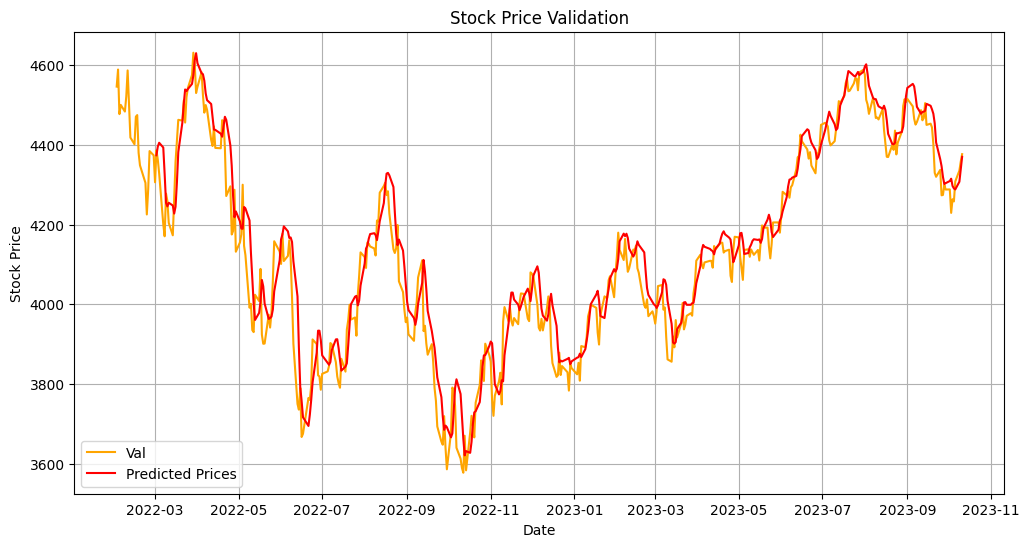

In [35]:
# Plot the actual historical data and predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(sp500.index[train_size:], prices[train_size:], label='Val', color='orange')
plt.plot(sp500.index[train_size+sequence_length : train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Validation')
plt.legend()
plt.grid()
plt.show()

# Future prediction

In [36]:
# Get the most recent sequence from your test data
last_sequence = test_sequences[-1]

print(test_sequences.shape)
print(last_sequence.shape)

(406, 20, 1)
(20, 1)


In [37]:
# Number of future time steps to predict
future_time_steps = 10  # Adjust as needed

future_predictions = []

for _ in range(future_time_steps):
    # Predict the next price
    next_price = model.predict(last_sequence.reshape(1, sequence_length, 1))

    # Append the predicted price to the list
    future_predictions.append(next_price[0, 0])

    # Update the last_sequence by removing the first element and adding the predicted price
    last_sequence = np.concatenate((last_sequence[1:], next_price), axis=None)

1/1 [==============================] - 0s 17ms/step


In [38]:
# Inverse transform the scaled predictions to original prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

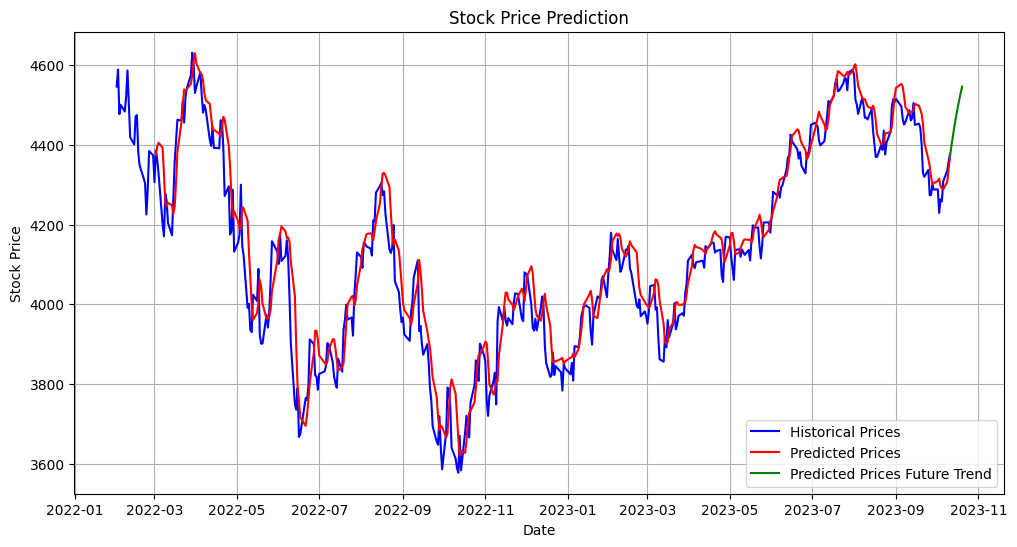

In [39]:
# Create a time axis for future predictions without the last element
time_axis = pd.date_range(start=sp500.index[-1], periods=future_time_steps)

# Plot the actual historical data and predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(sp500.index[train_size:], sp500['Close'][train_size:], label='Historical Prices', color='blue')
plt.plot(sp500.index[train_size+sequence_length:train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')
plt.plot(time_axis, future_predictions, label='Predicted Prices Future Trend', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid()
plt.show()



# Backtesting

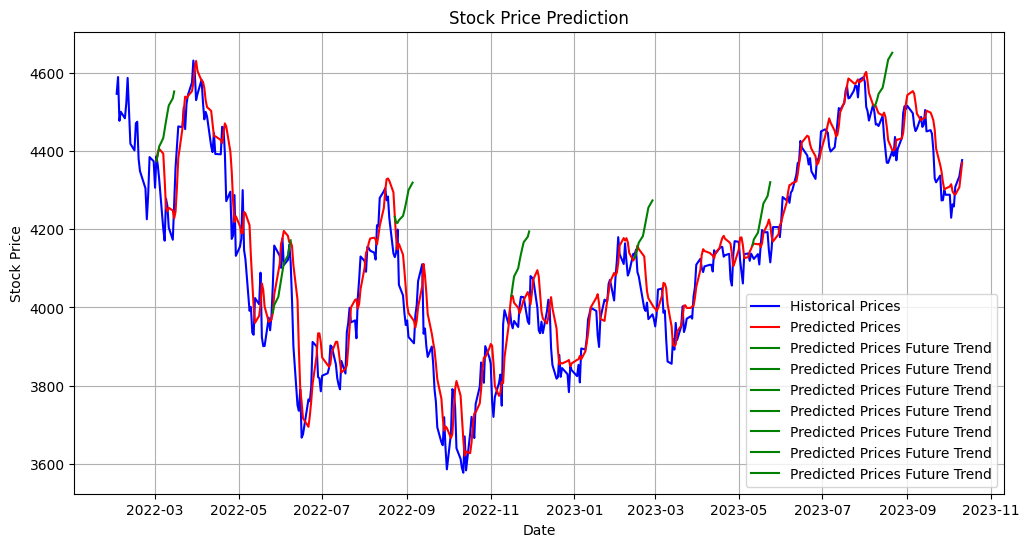

In [40]:
# Multiple predictions from multiple points

# Number of future time steps to predict
# future_time_steps = 10  # Adjust as needed

# How many days we want our predictions to starts from
start_day = 0
interval_gap = 60

fig = plt.figure(figsize=(12, 6))

# Plot the actual historical data and predicted future prices
fig = plt.plot(sp500.index[train_size:], sp500['Close'][train_size:], label='Historical Prices', color='blue')
plt.plot(sp500.index[train_size+sequence_length:train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')     # Works

for i in range(start_day, test_sequences.shape[0], interval_gap):
    # Get the most recent sequence from your test data
    last_sequence = test_sequences[i]
    # print(test_input.shape)
    # print(last_sequence.shape)
    future_predictions = []

    for j in range(future_time_steps):
        # Predict the next price
        next_price = model.predict(last_sequence.reshape(1, sequence_length, 1), verbose=0)

        # Append the predicted price to the list
        future_predictions.append(next_price[0, 0])

        # Update the last_sequence by removing the first element and adding the predicted price
        last_sequence = np.concatenate((last_sequence[1:], next_price), axis=None)

    # Inverse transform the scaled predictions to original prices
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



    # Create a time axis for future predictions
    # time_axis = pd.date_range(start=sp500.index[train_size+sequence_length+i], periods=future_time_steps + 1, closed='right')
    time_axis = pd.date_range(start=sp500.index[train_size+sequence_length+i], periods=future_time_steps + 1, freq='B')[:-1]
    # if j == future_time_steps - 1:
      # plt.plot(time_axis[:], future_predictions, label='Predicted Prices Future Trend', color='green') # sequence_length
    # plt.plot(time_axis[:], future_predictions, label='Predicted Prices Future Trend', color='green')


    plt.plot(time_axis, future_predictions, label='Predicted Prices Future Trend', color='green')
    # else:
    #   plt.plot(time_axis[:], future_predictions, color='green')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid()
plt.show()